# Identifying biases in the dataset

In this workbook we will use [pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information) to find biases in a given labeled dataset



In [1]:
import pandas as pd
import re
from matplotlib import pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from collections import Counter

import seaborn as sns
from functools import reduce



In [42]:
# Helping functions
HTML_TAGS = re.compile('<.+?>')
EXTRA_SPACE = re.compile('\s+')

def extract_label(text):
    matched = re.search('imSitu/(.*?)_\d+.jpg',text)
    return matched.groups()[0]

def remove_html_tags(str):
    '''
    Examples:
    >>> remove_html_tags('<p> remove this! <\p>')
    'remove this!'

    >>> remove_html_tags('<p> now TRY this <\p>')
    'now try this'

    >>> remove_html_tags('<p> and <\p> THIS')
    'and this'
    '''
    clean_text =  HTML_TAGS.sub('',str).strip()
    clean_text = EXTRA_SPACE.sub(' ',clean_text)
    return clean_text

def clean_text(txt):
    #remove html tags
    clean_txt = remove_html_tags(txt)
    # remove twitter handles
    clean_txt = re.sub(r'@\w+',' ',clean_txt)
    # remove retweets
    clean_txt = re.sub(r'(^| )RT ',' ',clean_txt)
    # remove words with non-alphanumeric characters
    clean_txt = re.sub(r'[!@#:,.]',' ',clean_txt)
    # remove numbers
    clean_txt = re.sub(r'\b[0-9]+\b',' ',clean_txt)
    # remove extra spaces
    clean_txt = re.sub(r' +',r' ',clean_txt)
    clean_txt = clean_txt.lower()
    return clean_txt

def gen_term_dict(df):
    cv = CountVectorizer(binary=True,ngram_range=(1,1),stop_words='english')
    terms = cv.fit_transform(df['clean_text'])
    counter = terms.sum(axis=0).squeeze().tolist()[0]
    sorted_voc = {k:v for k,v in sorted(cv.vocabulary_.items(),key=lambda item:item[1])}
    terms_dict = {k:v for k,v in zip(sorted_voc.keys(),counter)}
    return terms_dict

def compute_metrics(label):
    P_term = {k:v/X_train.shape[0] for k,v in all_dict.items()}
    P_term_label = {k:v/labels_df[label].shape[0] for k,v in labels_dict[label].items()}
    pmi_label = {k:np.log2(v/P_term[k]) for k,v in P_term_label.items()}
    weight_label = {k:-np.log2(v/text_df.shape[0]) for k,v in labels_dict[label].items()}
    lmi_label = {k:v/weight_label[k] for k,v in pmi_label.items()}
    return pmi_label,lmi_label

def plot_mi(mi_type,results_dict):
    fig, ax = plt.subplots(ncols= min(4,len(labels)),nrows=int(np.ceil(len(labels)/min(4,len(labels)))),figsize=(20,8*int(np.ceil(len(labels)/4))))
    for i in range(len(labels)):
        sns.set(font_scale = 2.5)
        if ax.ndim==1:
            cur_ax = ax[i]
        else:
            cur_ax = ax[int(i/4),i%4]
    
        terms_df = results_dict[mi_type].sort_values(f'{labels[i]}_{mi_type}')
        sns.barplot(x='term',y=f'{labels[i]}_{mi_type}',data=terms_df[~terms_df[f'{labels[i]}_{mi_type}'].isnull()].iloc[-20:],color='blue',ax=cur_ax,label=labels[i])
        cur_ax.tick_params(axis='x',rotation=90)
        cur_ax.set_title(f'{labels[i]} {mi_type}')
    
        if len(labels) == 2:
            sns.barplot(x='term',y=f'{labels[1-i]}_{mi_type}',data=terms_df[~terms_df[f'{labels[i]}_{mi_type}'].isnull()].iloc[-20:],color='red',ax=cur_ax,label=labels[1-i])
        cur_ax.legend()


In [3]:
data_path = 'imsitu_sample.csv' #the location of the captions CSV file
label_col = 'path' #the name of the column that includes the label
text_col = 'text' # the name of the column that includes the captions

In [6]:
text_df = pd.read_csv(data_path)
text_df['label'] = text_df[label_col]
text_df['label'] = text_df['label'].apply(extract_label)
text_df.loc[text_df['label']!='cooking','label'] = 'not_cooking'

In [7]:
text_df.shape

(1244, 5)

In [8]:
text_df['label'].value_counts()

not_cooking    1000
cooking         244
Name: label, dtype: int64

In [9]:
X_train = text_df.copy()
X_train['clean_text'] = X_train[text_col].apply(clean_text)
labels = text_df['label'].unique()

In [11]:
# count the terms in each label

labels_df = {}
all_dict = {}
labels_dict = {}
for label in labels:
    labels_df[label] = X_train[X_train['label']==label].copy()
    labels_dict[label] = gen_term_dict(labels_df[label])
    all_dict = dict(Counter(all_dict)+Counter(labels_dict[label]))

In [12]:
#Compute the pointwise mutual information (PMI) and a localized/normalized mutual 
# information measures (LMI) for each term

mi_dict = {"PMI":{},"LMI":{}}

for label in labels:
    pmi,lmi = compute_metrics(label)
    mi_dict["PMI"][label] = pd.DataFrame([pmi]).T.rename(columns={0:f'{label}_PMI'})
    mi_dict["LMI"][label] = pd.DataFrame([lmi]).T.rename(columns={0:f'{label}_LMI'})

results_dict = {}
for k in mi_dict.keys():
    results_dict[k] = reduce(lambda x,y:pd.merge(x,y,left_index=True,right_index=True,how='outer'),mi_dict[k].values()).reset_index().rename(columns={'index':'term'})

## Plot The Results

Features that are correlated with the label will have positive normalized PMI. The higher the PMI, the stronger the correlation.

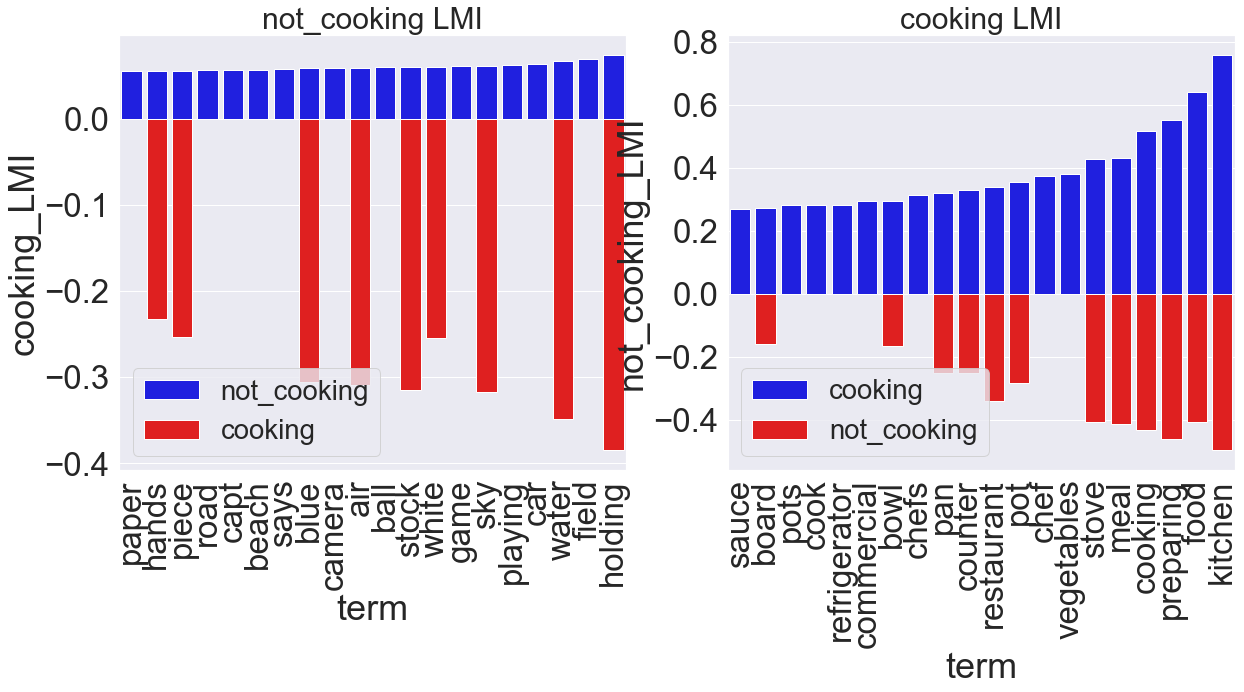

In [43]:
mi_type = "LMI"
plot_mi(mi_type,results_dict)


### Responsible AI

We can utilize the PMI to identify biases on sensitive features such as gender, race etc.

In [16]:
sensitive_features = ['boy','girl','women','men','woman','man']

In [18]:
sensitive_df = results_dict['LMI'][results_dict['LMI']['term'].isin(sensitive_features)]

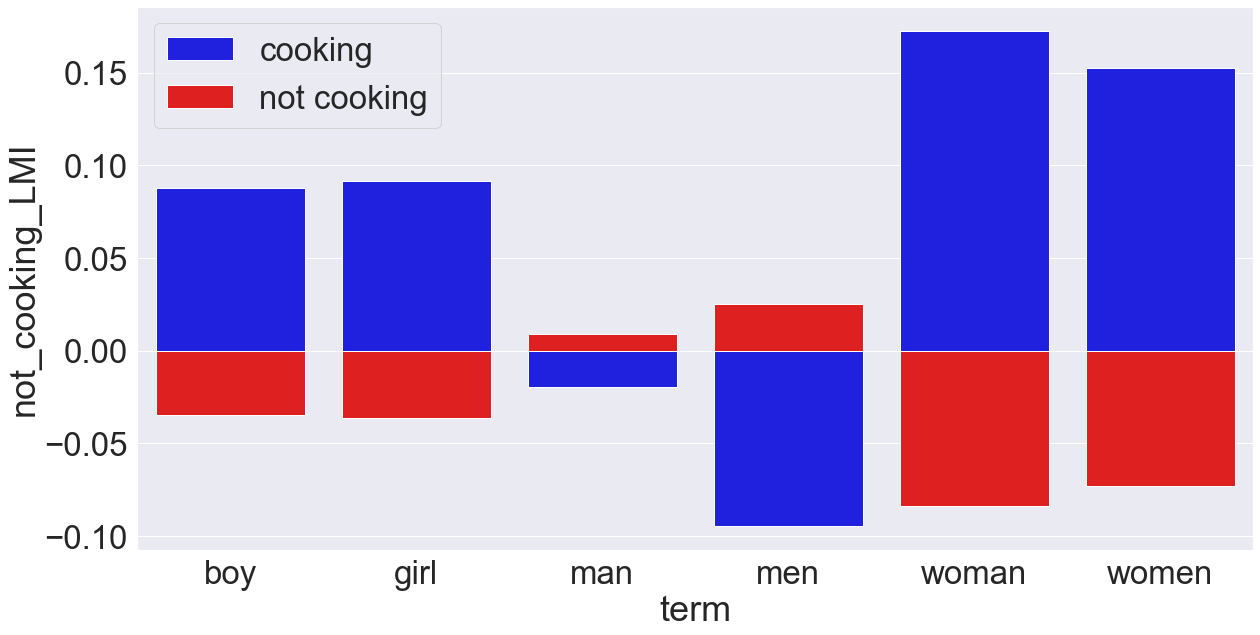

In [40]:
fig, ax = plt.subplots(ncols= 1,nrows=1,figsize=(20,10))
sns.set(font_scale = 3)
sns.barplot(x='term',y='cooking_LMI',data=sensitive_df,color='blue',ax=ax,label='cooking')
sns.barplot(x='term',y='not_cooking_LMI',data=sensitive_df,color='red',ax=ax,label='not cooking')
ax.legend()